In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
eeg_data_path = '/content/drive/MyDrive/Datasets/Epileptic Seizure Recognition Data Set.csv'

eeg_df = pd.read_csv(eeg_data_path)

eeg_df = eeg_df.drop(['ID'], axis = 1)

class0 = [2, 3, 4, 5]
class1 = [1]

for index, row in eeg_df.iterrows():
    if row['y'] in class0:
      row['y'] = 0
    elif row['y'] in class1:
      row['y'] = 1

positive_df = eeg_df.loc[eeg_df['y'] == 1]

In [ ]:
x_data = positive_df.drop('y', axis = 1)
y_data = positive_df[['y']]

In [ ]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(178)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'selu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name = "SigXNet-Discriminator")

discriminator.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-3), loss = tf.keras.losses.binary_crossentropy, metrics = ['accuracy'])
discriminator.summary()

Model: "SigXNet-Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 178)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               22912     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 23,041
Trainable params: 23,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
latent_dim = 100

generator = tf.keras.models.Sequential([
    tf.keras.Input(shape=(latent_dim)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(178),
], name = "SigXNet-Generator")

generator.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-3), loss = tf.keras.losses.binary_crossentropy, metrics = ['accuracy'])
generator.summary()

Model: "SigXNet-Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_7 (Dense)              (None, 178)               22962     
Total params: 35,890
Trainable params: 35,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = tf.keras.models.Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.SGD(lr = 1e-3))
    return gan

gan = create_gan(discriminator, generator)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
SigXNet-Generator (Sequentia (None, 178)               35890     
_________________________________________________________________
SigXNet-Discriminator (Seque (None, 1)                 23041     
Total params: 58,931
Trainable params: 35,890
Non-trainable params: 23,041
_________________________________________________________________


In [ ]:
disc_loss = []
gene_loss = []
epochs = 5 
batch_size = 128
x_train = x_data.to_numpy()

for e in range(epochs):
    for _ in range(batch_size):
        noise = np.random.normal(0, 1, [batch_size, 100])
        generated_signal = generator.predict(noise)
       
        signal_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)]
        x = np.concatenate([signal_batch, generated_signal])
        
        y_disc = np.zeros(batch_size * 2) 
        y_disc[:batch_size] = 1 

        discriminator.trainable = True
        discriminator_loss = discriminator.train_on_batch(x, y_disc)

        noise = np.random.normal(0, 1, [batch_size, 100])
        y_gene = np.ones(batch_size)

        discriminator.trainable = False
        generator_loss = gan.train_on_batch(noise, y_gene)

        disc_loss.append(discriminator_loss)
        gene_loss.append(generator_loss)
        
    if (e % 2 == 0) or (e == epochs - 1):
        print("Epochs: ", e)
    if e == epochs-1:
        print("Training Complete")

Epochs:  0
Epochs:  2
Epochs:  4
Training Complete


In [ ]:
generator.save("generator.h5") # you can donwload this model from output part of this kernel.
discriminator.save("discriminator.h5") # you can donwload this model from output part of this kernel.

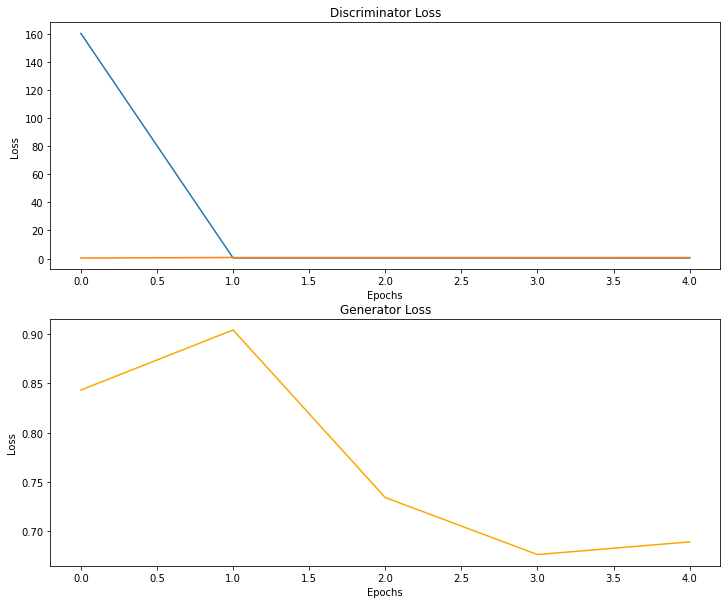

In [ ]:
import matplotlib.pyplot as plt

index = 0
D_loss2 = []
G_loss2 = []

for i in range(1,epochs+1):
    D_loss2.append(disc_loss[index])
    G_loss2.append(gene_loss[index])
    index += batch_size

fig, axs = plt.subplots(2, 1, figsize = (12,10))

axs[0].plot(D_loss2, label = "Discriminator Loss")
axs[1].plot(G_loss2, label = "Generator Loss", color = "orange")

axs[0].set_xlabel("Epochs")
axs[1].set_xlabel("Epochs")

axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Loss")

axs[0].set_title("Discriminator Loss")
axs[1].set_title("Generator Loss")
plt.show()

In [ ]:
samples = 5
noise = np.random.normal(0, 1, (samples,100))
audios = generator.predict(noise)

In [ ]:
audios.shape

(5, 178)

In [ ]:
discriminator.predict(audios)

array([[0.693274  ],
       [0.64137805],
       [0.4930314 ],
       [0.6831992 ],
       [0.3690106 ]], dtype=float32)

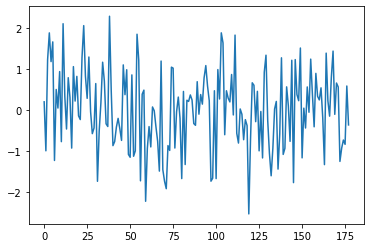

In [ ]:
plt.plot(audios[4])

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 10  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

gan.fit(
    x_data, y_data, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)